## Baseline Models  
### NZ Energy Demand Forecasting  

This is our first forecasting efforts in our series on forecasting New Zealand's energy demand. [Stats NZ are tracking](https://www.stats.govt.nz/experimental/covid-19-data-portal) the nation's energy consumption throughout the COVID-19 lockdown and post-lockdown recovery. It's an indicator of "typical economic activity" in New Zealand, which took a sudden and dramatic dive during lockdown and which is quicky tracking back to normal as the nation returns to work.   

<br></br>  
Following our introduction post, this is our first efforts at developing a simple, but accurate baseline forecasting model. Here at Flock, our approach to forecasting is simple:  
  

  - we embrace domain expertise and develop data-driven models alongside domain-centric theories    

  - we start with simple baseline models  
    - these allow us to get to know your data well  
    - they give us a baseline accuracy, a sense of what is achievable and a baseline measure to evaluate future improvements  
    - they let us to quickly expose the tougher aspects of your data and your forecasting challenge, so that future iterations are targeted to where they're needed most    
      
      
  - models are developed iteratively, alongside the business, to continually improve and continually drive insight into your business problem  


With these points in mind, our baseline model will be a combination of historical data and an "expert model".  We'll use machine learning to combine these two approaches, learn suitable adjustments and weightings for each and establish an accurate, highly-interpretable baseline model.


<br></br>  
### The Data  

You'll have already seen the data in our intro post. But let's take another quick look, then dive in a little deeper.

In [1]:
! pip install -q arviz

     |████████████████████████████████| 1.5MB 7.9MB/s 
     |████████████████████████████████| 4.1MB 48.3MB/s 
     |████████████████████████████████| 327kB 57.5MB/s 


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow.compat.v1 as tf  # essential to reset the graph and train more than one model
import tensorflow_probability as tfp
import arviz as az

tfd = tfp.distributions 
tfb = tfp.bijectors

demand = pd.read_csv("https://raw.githubusercontent.com/nickb-/nz-energy-demand-forecasting/master/data/nz-energy-data.csv")
demand.columns = ['ID', 'class', 'category', 'indicator_name', 'series_name', 'date', 'demand', 'units']
demand.date = pd.to_datetime(demand.date)

demand.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,ID,class,category,indicator_name,series_name,date,demand,units
0,1,Economic,Activity,Electricity grid demand,New Zealand,2015-02-01,98.616,Gigawatt hours
1,2,Economic,Activity,Electricity grid demand,New Zealand,2015-02-02,108.109,Gigawatt hours
2,3,Economic,Activity,Electricity grid demand,New Zealand,2015-02-03,108.902,Gigawatt hours
3,4,Economic,Activity,Electricity grid demand,New Zealand,2015-02-04,107.218,Gigawatt hours
4,5,Economic,Activity,Electricity grid demand,New Zealand,2015-02-05,105.561,Gigawatt hours


We have daily energy demand readings from across New Zealand, going back to 2015:

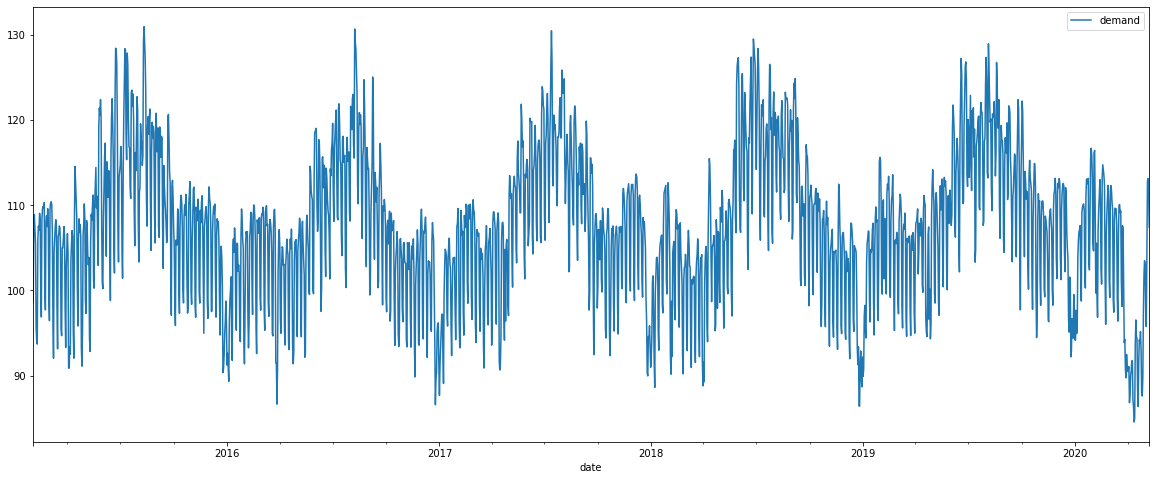

In [3]:
demand[demand.series_name == 'New Zealand'].plot(x = 'date', y = 'demand', figsize=(20, 8))

The demand is further broken down into regions:

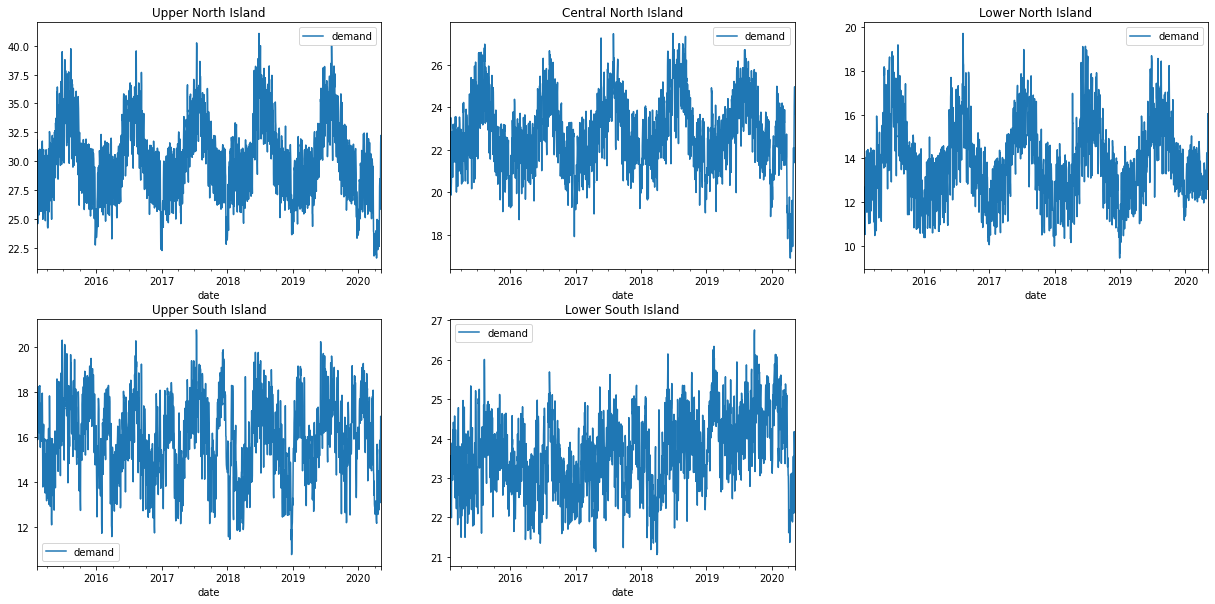

In [4]:
plt.figure(figsize=(21,10))
for i, region in enumerate(['Upper North Island', 'Central North Island', 'Lower North Island', 'Upper South Island', 'Lower South Island']):
  
  demand[demand['series_name'] == region].plot(x = 'date', y = 'demand', title=region, ax = plt.subplot(2,3,i+1))
  
plt.show()

We dug into this a bit more in our intro post, but the highlights include:  

  - there is strong seasonality, with demand peaking in Winter (we assume this relates to heating)  
  - The three North Island regions are all quite similar. They all show the same Summer/Winter seasonality and all show "holiday effects", notably around Christmas and New Year.  
  - The South Island is a different beast, and whilst the Upper South Island has a similar Summer/Winter seasonal trend, it isn't as notable as the North Island. We believe this is probably due to tourism and the summer horticulture demands (in particular wine making in Marlborough).  

Given these observations, it makes sense to separate the North Island from the South Island, and even to model the Upper and Lower South Island separately. For simplicity here (given these are only our initial baseline models), we will focus on the simpler North Island trends and return to the South Island in future work.  

<br></br>  
### Seasonal Breakdowns  

We've already identified the strong Summer/Winter contrast:  

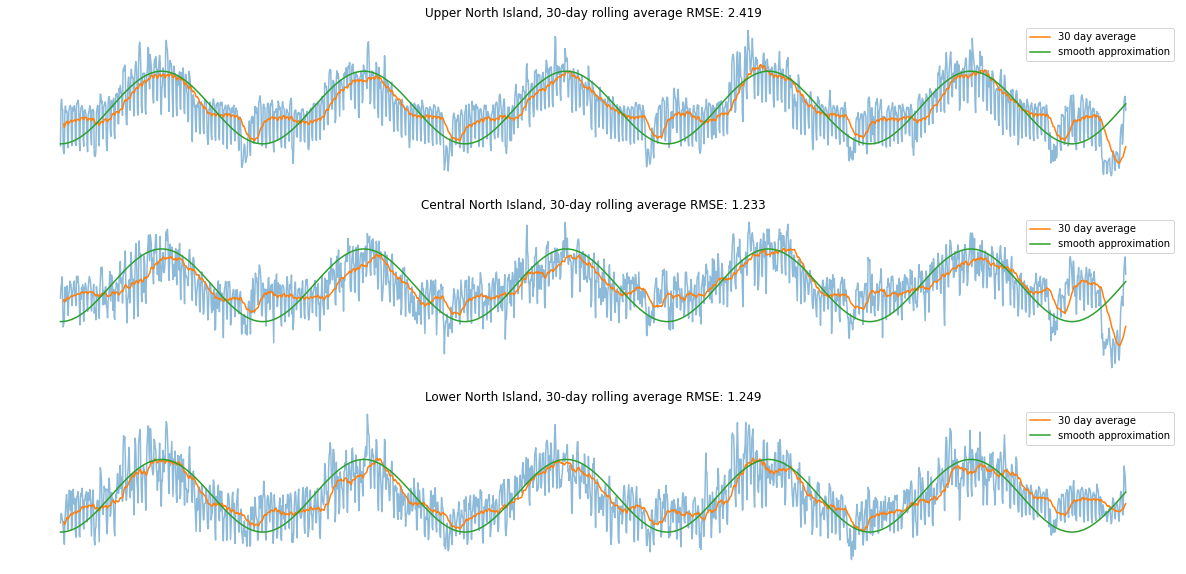

In [5]:
north = demand.query("series_name in ['Upper North Island', 'Central North Island', 'Lower North Island']")

rmse = lambda y,yhat: np.sqrt(np.mean( (y - yhat)**2 ))

plt.figure(figsize=(21,10))
for i, region in enumerate(['Upper North Island', 'Central North Island', 'Lower North Island']):

  tmp = north[north['series_name'] == region]
  rolling_average = tmp.iloc[:,6].rolling(30, min_periods=7).mean()
  
  ax = plt.subplot(3, 1 ,i+1)
  ax.plot(tmp['date'], tmp['demand'], alpha=0.5)
  ax.plot(tmp['date'],rolling_average , label='30 day average')
  ax.plot(tmp['date'], np.mean(tmp.demand) + -0.25*(np.max(tmp.demand) - np.min(tmp.demand)) * np.cos(1./18.5 * np.arange(0, tmp.shape[0]) / np.pi), label = 'smooth approximation')
  plt.title(f"{region}, 30-day rolling average RMSE: {np.round(rmse(tmp.demand, rolling_average), 3)}")
  plt.legend()
  plt.axis('off')
  
plt.show()

At a very basic level, we can approximate the Summer/Winter trend with a simple smooth function (shown in green above). If we're generous to ourselves, we might call this an "expert model" of the seasonal trend. And it's actually not bad.  


I'd go as far as saying that our smooth "expert model" is better than a 30-day moving average (shown in yellow above). They both move and respond to the major seasonal trend, but the moving average is a lot more sensitive to short-term changes in demand. As a first cut, and a rough approximation, our "expert model" is more likely to forecast future demand better than the moving average.  


<br></br>  
However, this only addresses (which I use lightly) one seasonal aspect of the data. Let's zoom in closer:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

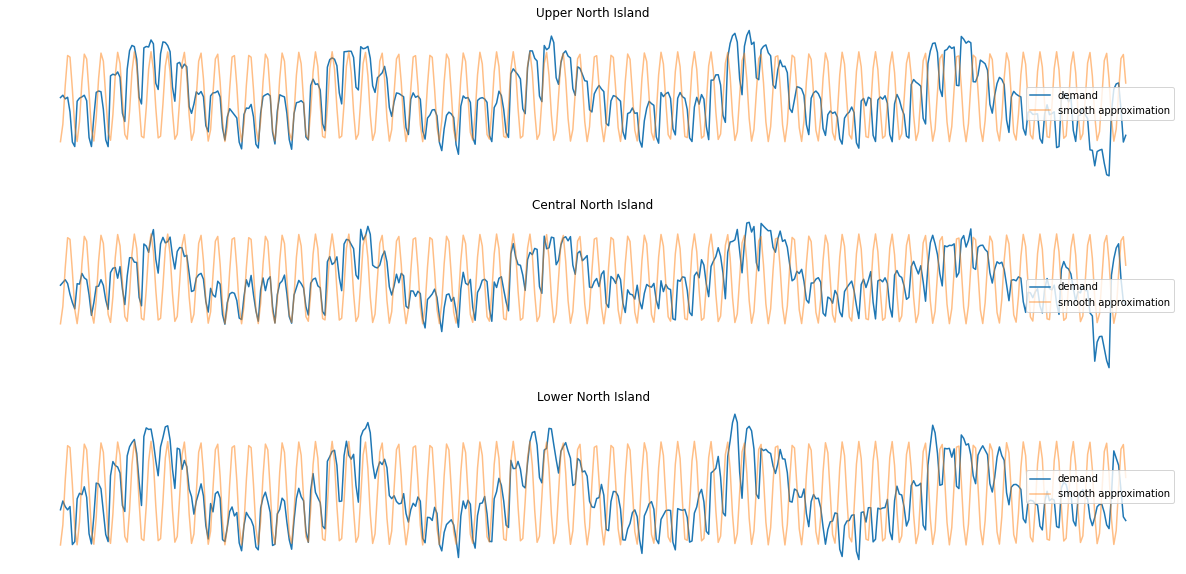

In [6]:
# Create date-part features to make this easier to visualise
north['TheYear'] = north.date.dt.year
north['TheMonth'] = north.date.dt.month
north['TheWeek'] = north.date.dt.weekofyear
north['TheWeekday'] = north.date.dt.dayofweek
north['TheDayOfYear'] = north.date.dt.dayofyear

# Weekly seasonality
plt.figure(figsize=(21,10))
for i, region in enumerate(['Upper North Island', 'Central North Island', 'Lower North Island']):

  tmp = north[north['series_name'] == region][['TheYear', 'TheMonth', 'TheWeekday', 'demand']]

  ax = plt.subplot(3, 1 ,i+1)
  tmp.groupby(by = ['TheYear', 'TheMonth', 'TheWeekday'])\
     .mean()\
     .plot(ax=ax, label='Weekly trend')
  
  ax.plot(np.arange(0, 448), 
          np.mean(tmp.demand) + -0.25*(np.max(tmp.demand) - np.min(tmp.demand)) * np.cos(10. * 2./7. * np.arange(0, 448) / np.pi), 
          label = 'smooth approximation',
          alpha=0.5)

  plt.title(region)
  plt.legend(loc='right')
  plt.axis('off')
  
plt.show()

There is also a strong weekly trend here.  

  - electricity demand is the highest during the working week (Monday - Friday)   
  - demand drops during the weekend  
  - the pattern is consistent across all three North Island regions  

Clearly, there is a pattern here that relates to the working week. It's a shame that we don't have hourly data. If we did, I suspect that we would see a similar trend for each how of the day: lowest during the early hours of the morning, climbing up through the workday and possibly peaking as people return home, heat the home and prepare dinner.  

As before, we've added a smooth approximation of the weekly trend. But unlike the previous "expert model", this isn't a good approximation of the weekly trend, because unlike the monthly trend, the weekly trend is not smooth. The electricity demand does not smoothly increase throughout the week up until Wednesday, then gradually lower again. It's easy to show this:

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


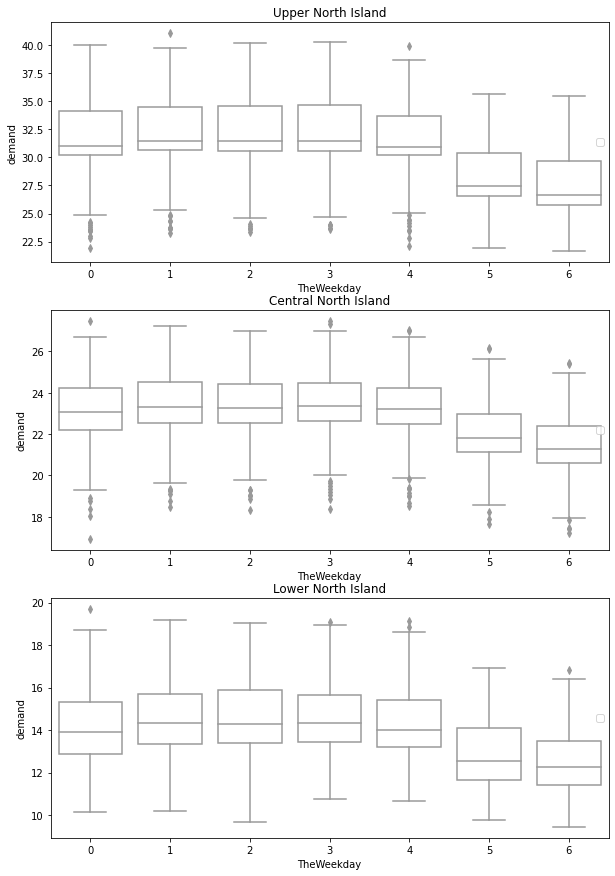

In [7]:
plt.figure(figsize=(10, 15))
for i, region in enumerate(['Upper North Island', 'Central North Island', 'Lower North Island']):

  tmp = north[north['series_name'] == region][['TheYear', 'TheMonth', 'TheWeekday', 'demand']]

  ax = plt.subplot(3, 1 ,i+1)
  sns.boxplot(x = 'TheWeekday', y = 'demand', data = tmp, ax=ax, color='white')

  plt.title(region)
  plt.legend(loc='right')
  
plt.show()

Above we can see what is really going on each day of the week. The weekdays (0 - 4) are much higher compared to the weekends (days 5 & 6). Interestingly, Sunday is a little lower, on average, compared to Saturday - which again might reflect a pattern which relates to work, which many retail and hospitality outlets having reduce Sunday trading times.  

<br></br>  

The question then, is which do we use to capture these weekly trends? Do we use the smooth "expert model", or do we use a "daily average model"?   

I'm leaning towards the "daily average model", at least initially. We'll build this into our machine learning model. Then, if we need to smooth our forecasts further, we'll add the smooth "expert model" on top of this to help the forecasts transition smoothly. This way, we get the best of both worlds. The machine learning algorithm can learn to balance the two approaches and weight them to give the most accurate forecasts.  

<br></br>  
That's as far as we can go with this data for now. If we had more fine-grained data we could look at daily and hourly patterns. But we've effectively covered the long-term trend (there isn't one, it doesn't increase year-on-year), found a way to describe the yearly/monthly seasonality and the weekly patterns. Time to build our first model.  

<br></br>  
### Baseline Model  

As always, we will build our model up over a number of iterations. At each step, we'll train our algorithm and evaluate the fit to the data. Then we will add additional complexity to the model one piece at a time. If extra features add to the accuracy (and insights!) of the model, we'll keep them. If they don't add anything, we'll discard them.  

<br></br>  
**Model One**: so then, our first model will be a simple monthly/daily average model. In addition to that, we'll add separate terms for each region. It's important to note that the general trends are the same for all three North Island region, they just sit at different levels (Upper North Island is the highest and Lower North Island has the lowest demand).

For those who are interested, we are going to train our model using Tensorflow Probability (TFP). Probabilistic modelling allows us to define a highly flexible and customisable "structure" to describe the data - a "data generating process". In addition, it will allow us to estimate the *uncertainty* in our predictions, which is always important. Finally, TFP is fast! At least compared to other probabilistic languages. But, this isn't a guide to Bayesian modelling or TFP!

Before we define our model, there is some boilerplate code that we need. We on'y have to define this initially, so that we can sample from our Monte Carlo process.

In [0]:
class MonteCarloEngine:

    def __init__(self):
        self.session = None
        self.run = tf.function(
            self.sampler, autograph=False, experimental_compile=True
        )

    def reset_session(self, config = None):
        tf.reset_default_graph()

        try:
            self.session.close()
            tf.InteractiveSession.close()
        except:
            pass

        self.session = tf.InteractiveSession(config = config)

    def trace_function(self, samples, pkr):
        return (
            pkr.inner_results.inner_results.target_log_prob,
            pkr.inner_results.inner_results.leapfrogs_taken,
            pkr.inner_results.inner_results.has_divergence,
            pkr.inner_results.inner_results.energy,
            pkr.inner_results.inner_results.log_accept_ratio
        )

    def get_trace_stats(self, trace, statnames = ['log_likelihood', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']):
      return az.from_dict(sample_stats = {k:v.numpy().T for k, v in zip(statnames, trace)})

    def compare_models(self, traces = [], labels = []):
      return az.compare({
          lab:self.get_trace_stats(trace) for lab,trace in zip(labels, traces)
      })

    def sampler(
        self, 
        model = None,    # log-probability function
        nparams = None,  # number of parameters
        inits = None,    # initialisation for parameters
        trace_fn = None, # trace function
        iters = 2000,    # number of MCMC iterations
        warmup = 1000,   # warmup iterations
        chains = 1,
        bijectors_list = None
    ):
    
        if not isinstance(inits, list):
            inits = [0.01] * nparams

        # I don't understand this part yet...
        # Dig into this in the future
        if bijectors_list is None:
            bijectors_list = [tfb.Identity()] * nparams

        kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
            tfp.mcmc.TransformedTransitionKernel(
                inner_kernel=tfp.mcmc.NoUTurnSampler(
                    target_log_prob_fn = model,
                    step_size=1.0
                ),
                bijector=[tfb.Identity()] * nparams
            ),
            target_accept_prob=.8,
            num_adaptation_steps=np.floor(0.5*warmup),
            step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
                    inner_results=pkr.inner_results._replace(step_size=new_step_size)
                ),
            step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
            log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio,
        )

        samples, trace = tfp.mcmc.sample_chain(
            num_results = iters,
            num_burnin_steps = warmup,
            current_state = inits,
            kernel = kernel,
            trace_fn = trace_fn
        )

        return [samples, trace]

mcmc_engine = MonteCarloEngine()

Now, we can define our model as a combination of Region, Month, Day. For those of you who are mathematically-minded, our model will take the form:

$$
demand \sim Normal(\mu, \sigma)  \\    
\mu_{i} = \alpha + \beta_{1,region_i} + \beta_{2,month_i} + \beta_{3,day_i} + \epsilon  \\  
\alpha \sim Normal(0, 1) \\  
\beta_{1,2,3} \sim Normal(0, \tau_{1,2,3})  \\  
\tau_{1,2,3} \sim HalfCauchy(0, 1)  \\  
\sigma \sim HalfCauchy(0, 1)
$$  

Where $\beta_{1,2,3}$ are hierarchical intercepts, or offsets from the global mean, $\alpha$.  


<br></br>In simple terms, this model is a "historical average model". It will combine the historical average for a given region, month and day-of-week, using machine learning to develop the most accurate weighting of these averages. It's about as simple as you could get, while still delivering a good level of precision.

In [9]:
mcmc_engine.reset_session()

# Prepare the data
[daily_demand, region, month, day] = [
    tf.cast((north.demand - 20.) / 5., dtype=tf.float32),   # roughly centered and scaled
    tf.cast([0 if x == 'Lower North Island' else 1 if x == 'Central North Island' else 2 for x in north.series_name.values], dtype=tf.int32),
    tf.cast(north.TheMonth - 1, dtype=tf.int32),            # zero-indexed
    tf.cast(north.TheWeekday, dtype=tf.int32)
]

# Define the model
demand_model = tfd.JointDistributionSequential(
    [
        # global mean and variance
        tfd.Normal(loc=0., scale=1., name='global_mean'),
        tfd.HalfCauchy(0.0, 1.0, name='sigma'),  
     
        # Hierarchical scale and intercepts for the regions  
        tfd.HalfCauchy(0.0, 1.0, name='var_region'),
        lambda var_region: tfd.Sample(tfd.Normal(loc=0.0, scale=var_region, name='rv_region'), sample_shape=3),    # There are 3 regions  
     
        # Hierarchical scale and intercepts for the month  
        tfd.HalfCauchy(0.0, 1.0, name = 'var_month'), 
        lambda var_month: tfd.Sample(tfd.Normal(loc=0.0, scale=var_month, name='rv_month'), sample_shape=12),      # 12 months a year
     
        # Hierarchical scale and intercept for the day  
        tfd.HalfCauchy(0.0, 1.0, name='var_day'), 
        lambda var_day: tfd.Sample(tfd.Normal(loc=0.0, scale=var_day, name='rv_day'), sample_shape=7),             # 7 days a week
     
        # Demand  
        lambda rv_day, var_day, rv_month, var_month, rv_region, var_region, sigma, global_mean: 
            tfd.Independent(
                tfd.Normal(
                    loc = global_mean + 
                          tf.gather(rv_region, region, axis=-1) +
                          tf.gather(rv_month, month, axis=-1) +
                          tf.gather(rv_day, day, axis=-1),
                    scale = sigma
                ), reinterpreted_batch_ndims=1
            )
    ]
)
def demand_jd_likelihood(*args):
  return demand_model.log_prob(*args + (daily_demand, ))

priors = demand_model.sample()
samples, trace_ = mcmc_engine.run(
    model = demand_jd_likelihood,
    nparams = len(priors) - 1,
    inits = priors[:-1],
    chains = 1,
    iters = 5000,
    warmup = 2000,
    trace_fn = mcmc_engine.trace_function
)

samples

[<tf.Tensor: shape=(5000,), dtype=float32, numpy=
 array([-0.63867277, -0.65856016, -0.66434836, ..., -0.36040828,
        -0.30284205, -0.35971853], dtype=float32)>,
 <tf.Tensor: shape=(5000,), dtype=float32, numpy=
 array([0.29979178, 0.29911742, 0.29456362, ..., 0.30283478, 0.30298018,
        0.3026209 ], dtype=float32)>,
 <tf.Tensor: shape=(5000,), dtype=float32, numpy=
 array([2.919359 , 2.9394605, 2.9306   , ..., 1.9614155, 1.938971 ,
        1.7738723], dtype=float32)>,
 <tf.Tensor: shape=(5000, 3), dtype=float32, numpy=
 array([[-0.67204916,  1.1119095 ,  2.6830287 ],
        [-0.6448597 ,  1.1462277 ,  2.7285826 ],
        [-0.6565181 ,  1.1333843 ,  2.7175655 ],
        ...,
        [-0.89308214,  0.89720964,  2.4745033 ],
        [-0.94314593,  0.8436714 ,  2.3992882 ],
        [-0.97679174,  0.8077747 ,  2.3704817 ]], dtype=float32)>,
 <tf.Tensor: shape=(5000,), dtype=float32, numpy=
 array([0.4043297 , 0.29784063, 0.37360385, ..., 0.27130875, 0.4204542 ,
        0.284387 

Before we look at our predictions, let's have a good look at our posteriors. If the MCMC chains have sampled well, the posteriors should be reasonably compact and uniform. I'd be suspicious of anything multimodal.  

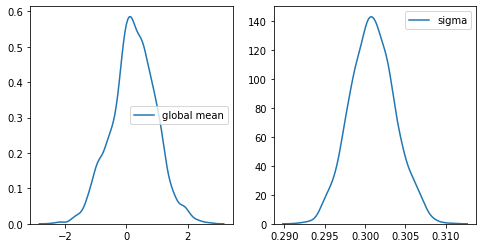

In [10]:
plt.figure(figsize=(8,4))
for i, (label, z) in enumerate(zip(['global mean', 'sigma'], samples[:2])):

  ax = plt.subplot(1, 2, i+1)
  sns.kdeplot(z.numpy(), label=label, ax=ax)

plt.show()

The `global_mean` and variance look good, and approx. what I expected for the global mean (remember we had centered and scaled our data).  

Next, let's look at the region intercepts:

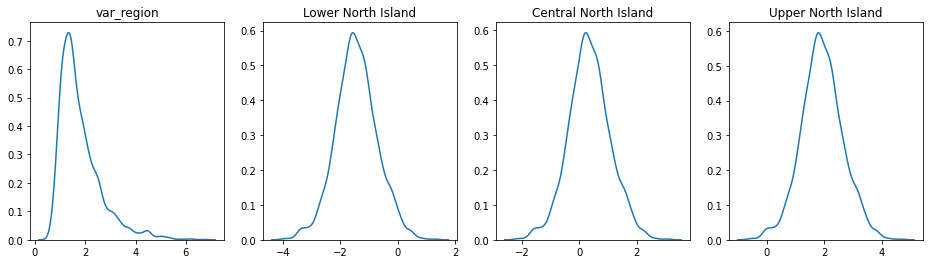

In [11]:
region_labels = ['var_region', 'Lower North Island', 'Central North Island', 'Upper North Island']
region_posteriors = [samples[2].numpy()] + [samples[3].numpy()[:,i] for i in range(3)]

plt.figure(figsize=(16,4))
for i, (label, z) in enumerate(zip(region_labels, region_posteriors)):

  ax = plt.subplot(1, 4, i+1)
  sns.kdeplot(z, ax=ax)
  plt.title(label)

plt.show()

These also look quite good. `var_region` confirms that there is quite a large difference between regions with: `Lower North Island` < `Central North Island` < `Upper North Island` as we would expect.

Next, let's look at the month and day effects:

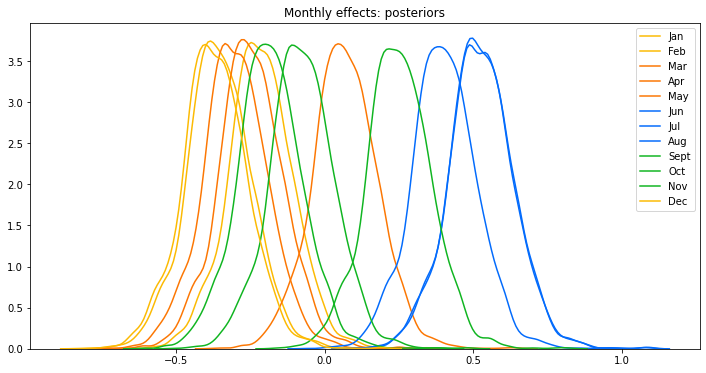

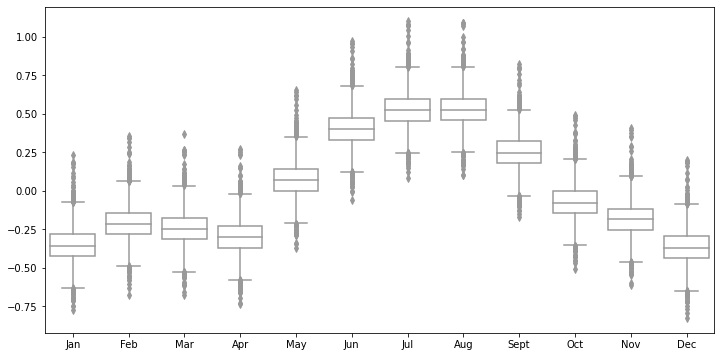

In [12]:
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
month_posteriors = [samples[5].numpy()[:,i] for i in range(12)]
colours = ['#fcba03', '#fcba03', '#fc7703', '#fc7703', '#fc7703',
           '#036bfc', '#036bfc', '#036bfc', '#10b521', '#10b521', '#10b521','#fcba03'] 

plt.figure(figsize=(12,6))
for i, (label, z, colour) in enumerate(zip(month_labels, month_posteriors, colours)):
  
  sns.kdeplot(z, label=label, color=colour)

plt.title("Monthly effects: posteriors")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x=month_labels, y=month_posteriors, color='white')
plt.show()

Again, we have well-formed posteriors and the Winter peaks have been captured nicely. 

April is a really interesting  month, it is lower than March and breaks a gentle swell of demand up into winter. There are a lot of public holidays in April, (Easter and Anzac Day), which might be pulling the average down similar to Jan and Dec.

Finally, let's look at the daily posteriors:

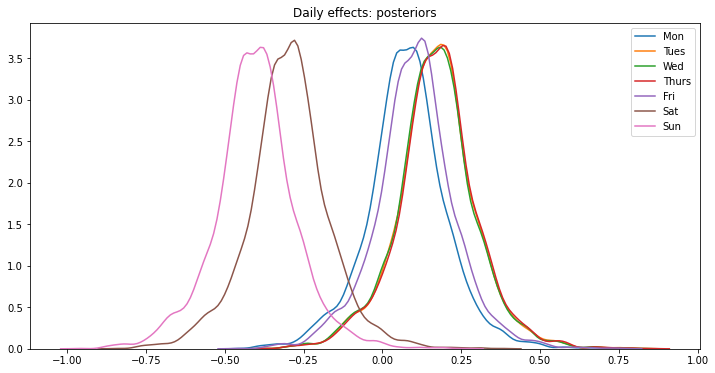

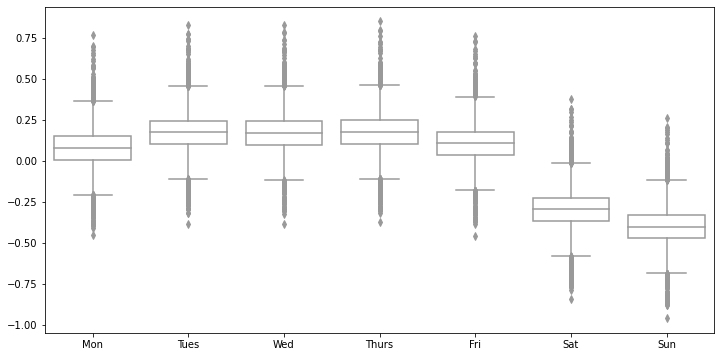

In [13]:
day_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
day_posteriors = [samples[7].numpy()[:,i] for i in range(7)]

plt.figure(figsize=(12,6))
for i, (label, z) in enumerate(zip(day_labels, day_posteriors)):
  
  sns.kdeplot(z, label=label)

plt.title("Daily effects: posteriors")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x=day_labels, y=day_posteriors, color='white')
plt.show()

And again, these look excellent. 

#### Model One: predictions  

Now, let's look at our predictions. These are in-sample predictions, but I am happy with that - we are looking at how well we capture the "data generating process" for now, and there is *no way* that we've overfit the data at this point.

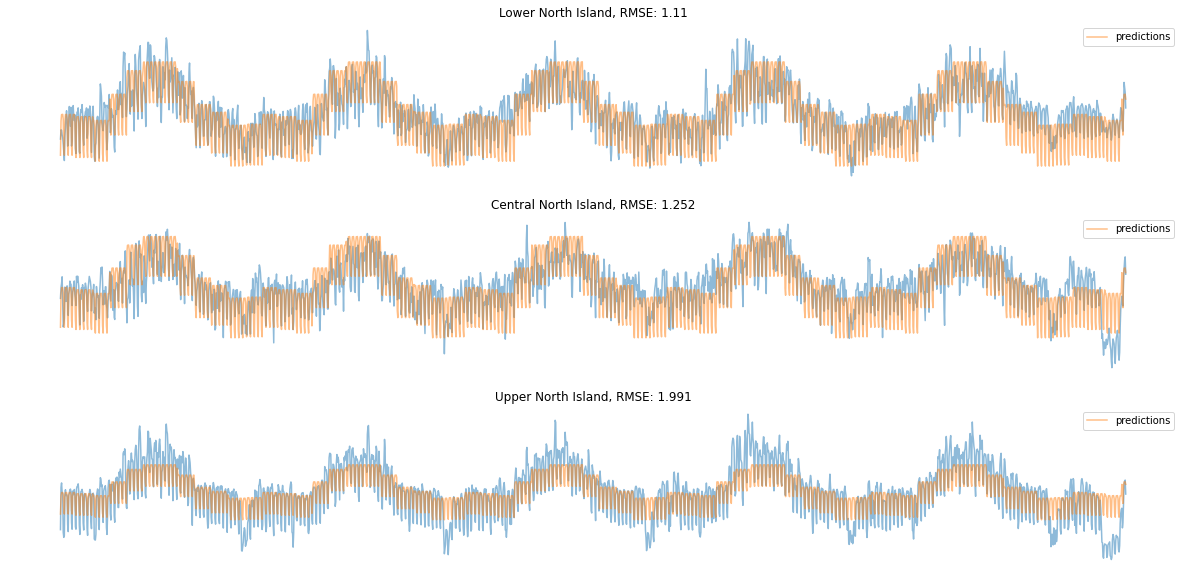

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
def predict(data):
  region, month, day = data
  alpha = samples[0].numpy()
  rv_region = samples[3].numpy()
  rv_month = samples[5].numpy()
  rv_day = samples[7].numpy()

  return np.mean(alpha + rv_region[:, region] + rv_month[:, month] + rv_day[:, day])

def rmse(y, yhat):  
  return np.sqrt(np.mean( (y - yhat)**2 ))

predictions = np.array([])
plt.figure(figsize=(21,10))
for i, region in enumerate(['Lower North Island', 'Central North Island', 'Upper North Island']):

  tmp = north[north['series_name'] == region]
  yhats = np.array([predict([i, tmp.TheMonth.values[x]-1, tmp.TheWeekday.values[x]]) for x in range(tmp.shape[0])])
  predictions = np.concatenate([predictions, yhats])
  
  ax = plt.subplot(3, 1 ,i+1)
  ax.plot(tmp['date'], tmp['demand'], alpha=0.5)
  ax.plot(tmp['date'], yhats * 5. + 20., label = 'predictions', alpha=0.5)
  plt.title(f"{region}, RMSE: {np.round(rmse(tmp.demand, yhats*5. + 20.), 3)}")
  plt.legend()
  plt.axis('off')
  
plt.show()

north['model_one_predictions'] = predictions

That is a promising first fit. It's a very good start for our baseline model. 

Keep in mind that our model is nothing more than a weighted average between:   

  - the historical regional average,   
  - the historical montlhy average,  
  - the historical day-of-week average  

This is about as naive/straight-forward as you can imagine, but it is a huge improvement in accuracy over a 30-day rolling average.  

<br></br>
### Model Two: Smoothing the predictions  

My first criticism of the model, is that it moves in a step-wise manner, from one month to the next. To smooth this out, let's add in our smooth "expert model" for demand throughout the year.

Our second model therefore, will be largely based on the "expert model". The hisotrical data will be used to adjust the "expert model" where necessary in order to improve the accuracy and precision of the model.  

<br></br>
Again, for those who are mathematically minded, the model will be as follows:

$$
demand \sim Normal(\mu, \sigma)  \\    
\mu_{i} = \alpha + \beta_{1,region_i} + \beta_{2,month_i} + \beta_{3,day_i} + \beta_4 * expert_i + \epsilon  \\  
\alpha \sim Normal(0, 1) \\  
\beta_4 \sim Normal(0, 1) \\  
\beta_{1,2,3} \sim Normal(0, \tau_{1,2,3})  \\  
\tau_{1,2,3} \sim HalfCauchy(0, 1)  \\  
\sigma \sim HalfCauchy(0, 1)
$$  

Where $\beta_{1,2,3}$ are hierarchical intercepts, or offsets from the global mean, $\alpha$, and the expert model. 


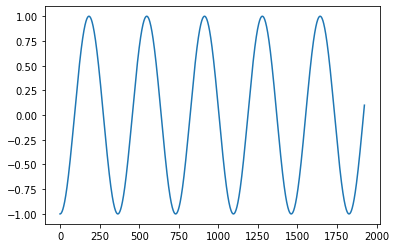

In [15]:
expert_approx = -1. * np.cos(1./18.5 * np.arange(north[north.series_name == 'Upper North Island'].shape[0]) / np.pi)
sns.lineplot(x = np.arange(north[north.series_name == 'Upper North Island'].shape[0]), y = expert_approx)

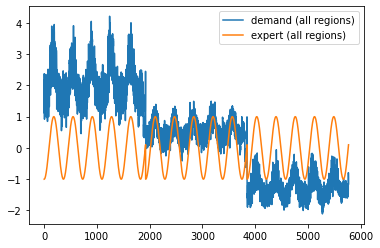

In [16]:
mcmc_engine.reset_session()

# Prepare the data
[daily_demand, region, month, day, expert] = [
    tf.cast((north.demand - 20.) / 5., dtype=tf.float32),   # roughly centered and scaled
    tf.cast([0 if x == 'Lower North Island' else 1 if x == 'Central North Island' else 2 for x in north.series_name.values], dtype=tf.int32),
    tf.cast(north.TheMonth - 1, dtype=tf.int32),            # zero-indexed
    tf.cast(north.TheWeekday, dtype=tf.int32),

    # Expert model
    # We'll assume the same model for each region initially 
    tf.cast(np.concatenate([expert_approx,expert_approx,expert_approx]), dtype=tf.float32)
]

sns.lineplot(x = np.arange(daily_demand.shape[0]), y=daily_demand, label = 'demand (all regions)')
sns.lineplot(x = np.arange(daily_demand.shape[0]), y=expert, label = 'expert (all regions)')

In [17]:
mcmc_engine.reset_session()

# Prepare the data
[daily_demand, region, month, day, expert] = [
    tf.cast((north.demand - 20.) / 5., dtype=tf.float32),   # roughly centered and scaled
    tf.cast([0 if x == 'Lower North Island' else 1 if x == 'Central North Island' else 2 for x in north.series_name.values], dtype=tf.int32),
    tf.cast(north.TheMonth - 1, dtype=tf.int32),            # zero-indexed
    tf.cast(north.TheWeekday, dtype=tf.int32),

    # Expert model
    # We'll assume the same model for each region initially 
    tf.cast(np.concatenate([expert_approx,expert_approx,expert_approx]), dtype=tf.float32)
]

# Define the model
demand_model = tfd.JointDistributionSequential(
    [
        # global mean and variance
        tfd.Normal(loc=0., scale=1., name='global_mean'),
        tfd.HalfCauchy(0.0, 1.0, name='sigma'),  
     
        # Hierarchical scale and intercepts for the regions  
        tfd.HalfCauchy(0.0, 1.0, name='var_region'),
        lambda var_region: tfd.Sample(tfd.Normal(loc=0.0, scale=var_region, name='rv_region'), sample_shape=3),    # There are 3 regions  
     
        # Hierarchical scale and intercepts for the month  
        tfd.HalfCauchy(0.0, 1.0, name = 'var_month'), 
        lambda var_month: tfd.Sample(tfd.Normal(loc=0.0, scale=var_month, name='rv_month'), sample_shape=12),      # 12 months a year
     
        # Hierarchical scale and intercept for the day  
        tfd.HalfCauchy(0.0, 1.0, name='var_day'), 
        lambda var_day: tfd.Sample(tfd.Normal(loc=0.0, scale=var_day, name='rv_day'), sample_shape=7),             # 7 days a week
     
        # Expert effects 
        tfd.Normal(loc=0.0, scale=1.0, name='rv_expert'),
     
        # Demand  
        lambda rv_expert, rv_day, var_day, rv_month, var_month, rv_region, var_region, sigma, global_mean: 
            tfd.Independent(
                tfd.Normal(
                    loc = global_mean + 
                          rv_expert * expert +
                          tf.gather(rv_region, region, axis=-1) +
                          tf.gather(rv_month, month, axis=-1) +
                          tf.gather(rv_day, day, axis=-1),
                    scale = sigma
                ), reinterpreted_batch_ndims=1
            )
    ]
)
def demand_jd_likelihood(*args):
  return demand_model.log_prob(*args + (daily_demand, ))

priors = demand_model.sample()
samples, trace_ = mcmc_engine.run(
    model = demand_jd_likelihood,
    nparams = len(priors) - 1,
    inits = priors[:-1],
    chains=2,
    iters = 2000,
    warmup = 1000,
    trace_fn = mcmc_engine.trace_function
)
samples

[<tf.Tensor: shape=(2000,), dtype=float32, numpy=
 array([0.87747085, 0.8765312 , 0.32558507, ..., 1.0418427 , 1.0381416 ,
        1.0224484 ], dtype=float32)>,
 <tf.Tensor: shape=(2000,), dtype=float32, numpy=
 array([0.29263556, 0.29476824, 0.29817408, ..., 0.29697406, 0.29718134,
        0.29935825], dtype=float32)>,
 <tf.Tensor: shape=(2000,), dtype=float32, numpy=
 array([1.4538524, 1.4574758, 2.0495183, ..., 1.1101305, 1.0851542,
        1.0748553], dtype=float32)>,
 <tf.Tensor: shape=(2000, 3), dtype=float32, numpy=
 array([[-1.9148425 , -0.11899919,  1.4475672 ],
        [-1.9075967 , -0.13371567,  1.4360553 ],
        [-1.705831  ,  0.10205613,  1.6583973 ],
        ...,
        [-2.191267  , -0.40417227,  1.1584328 ],
        [-2.1823735 , -0.39346275,  1.1743096 ],
        [-2.1901083 , -0.39847624,  1.1785362 ]], dtype=float32)>,
 <tf.Tensor: shape=(2000,), dtype=float32, numpy=
 array([0.14404611, 0.1459519 , 0.20954886, ..., 0.22462791, 0.2113144 ,
        0.24593456], dt

Let's have a quick look at our posteriors. There shouldn't have been any change in the regional effects or the daily effects:

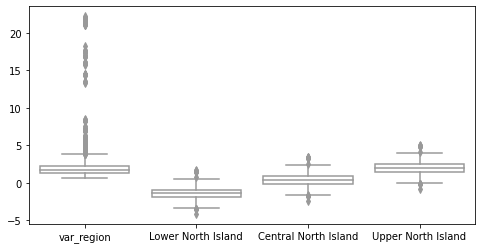

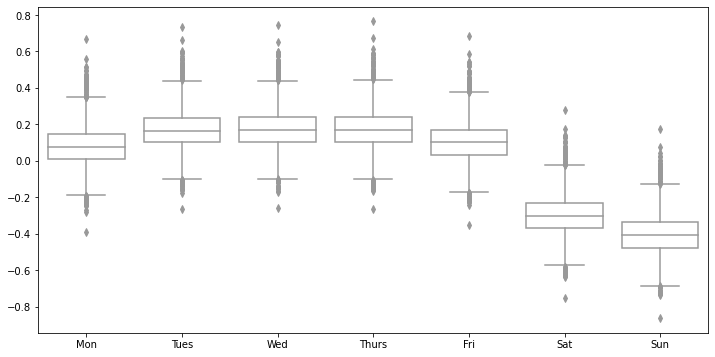

In [18]:
region_labels = ['var_region', 'Lower North Island', 'Central North Island', 'Upper North Island']
region_posteriors = [samples[2]] + [samples[3].numpy()[:,i] for i in range(3)]

plt.figure(figsize=(8,4))
sns.boxplot(x=region_labels, y=region_posteriors, color='white')
plt.show()

day_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
day_posteriors = [samples[7].numpy()[:,i] for i in range(7)]
plt.figure(figsize=(12,6))
sns.boxplot(x=day_labels, y=day_posteriors, color='white')
plt.show()

However, there should be subtle differences in the posteriors of our monthly effects:

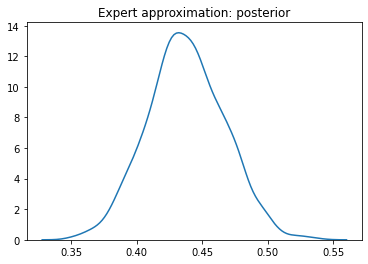

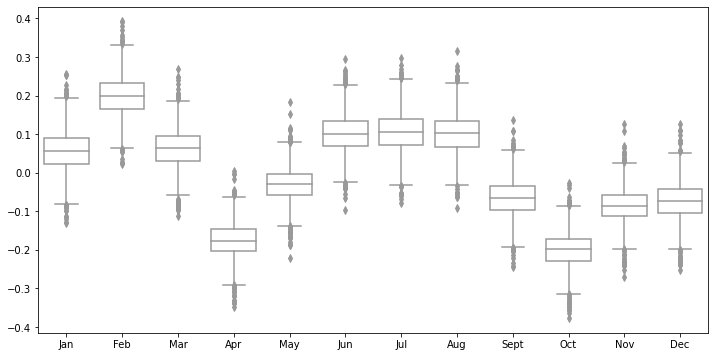

In [19]:
sns.kdeplot(samples[-1].numpy())
plt.title("Expert approximation: posterior")
plt.show()

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
month_posteriors = [samples[5].numpy()[:,i] for i in range(12)]
colours = ['#fcba03', '#fcba03', 
           '#fc7703', '#fc7703', '#fc7703',
           '#036bfc', '#036bfc', '#036bfc', 
           '#10b521', '#10b521', '#10b521','#fcba03']
plt.figure(figsize=(12,6))
sns.boxplot(x=month_labels, y=month_posteriors, color='white')
plt.show()

As expected, the monthly effects are now very different to a simple "historical monthly average". We've managed to incorporate our "expert model", and the monthly effects now represent offsets (or adjustments) from the expert model. It really highlights some interesting demand in Feb, Apr and Oct, which are really different from our "expert model".

Let's look at the predictions:

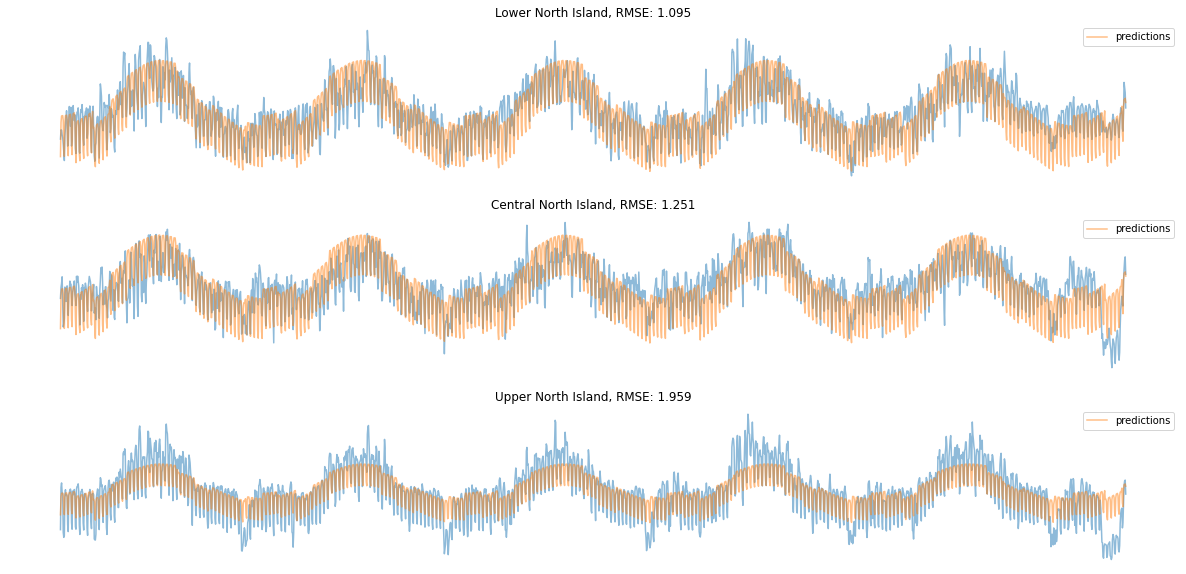

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
def predict(data):
  region, month, day, expert = data
  alpha = samples[0].numpy()
  rv_region = samples[3].numpy()
  rv_month = samples[5].numpy()
  rv_day = samples[7].numpy()
  rv_expert = samples[-1].numpy()

  return np.mean(alpha + rv_region[:, region] + rv_month[:, month] + rv_day[:, day] + rv_expert*expert)

predictions = np.array([])
plt.figure(figsize=(21,10))
for i, region in enumerate(['Lower North Island', 'Central North Island', 'Upper North Island']):

  tmp = north[north['series_name'] == region]
  yhats = np.array([predict([i, tmp.TheMonth.values[x]-1, tmp.TheWeekday.values[x], expert_approx[x]]) for x in range(tmp.shape[0])])
  predictions = np.concatenate([predictions, yhats])
  
  ax = plt.subplot(3, 1 ,i+1)
  ax.plot(tmp['date'], tmp['demand'], alpha=0.5)
  ax.plot(tmp['date'], yhats * 5. + 20., label = 'predictions', alpha=0.5)
  plt.title(f"{region}, RMSE: {np.round(rmse(tmp.demand, yhats*5. + 20.), 3)}")
  plt.legend()
  plt.axis('off')
  
plt.show()

north['model_two_predictions'] = predictions

That's a much smoother set of forecasts, which is good to see. The accuracy (RMSE) is also *slightly* improved with these smoother forecasts, based on our "expert model". This is a step in the right direction, but there is still some work to be done.


### Criticisms of our Baseline Model and Future Work  

So far, we have compared the use of a 30-day rolling average, a data-driven, weighted "historical averages" model and a combination of this with our "expert model". Each subsequent model has improved on the previous, both qualitatively and quantifiably (accuracy and precision). 

However, we can still improve on "expert model". Specifically:  

  - the expert model needs to be adapted for each region. Each region exhibits the same seasonal period. Nut, the magnitude of the expert model should vary for each region.  
  - in addition, our expert model has a hardcoded period. This is quite likely an oversimplification, and we should instead estimate the period from the data itself. Thus, we still respect the form of the expert model, but we use the data to construct and validate the specific model parameters.  
  - we should also account for "holiday effects", which are particularly obvious in the Upper North Island demand.  
  - finally, the forecasts are possible a little too uniform. If we solve the above challenges, then we should explore reasons why the actual demand might deviate from the "modelled demand". Intuitively, we might consider things like temperature and rainfall as additional factors in this model.  

So then, a good start and promising results. However, still some work to be done and we will continue to iterate on these models.

In [0]:
# Last, I am going to download the results for future reference
from google.colab import files

north.to_csv("./north_island_baseline_forecasts.csv", index=None)
files.download("./north_island_baseline_forecasts.csv")